# Enrichment Analyses
# Phase 1 vs. Phase 1

using [clusterProfiler](https://github.com/YuLab-SMU/clusterProfiler) R package

**Two analyses**
1. [Gene Set Enrichment Analysis](#gsea)
2. [Over-Representation Analysis](#ora)

# Gene Set Enrichment Analysis (GSEA)
<a id='gsea'></a>

uses an entire ranked list (by log2FoldChange) of genes to see if pathway genes cluster at the top or bottom

#### Are *pathways* generally over- or under-expressed in a given treatment?

## 0. load libraries

In [55]:
library(tidyverse)
library(clusterProfiler) # for GSEA()
library(enrichplot) # for enrichment visuals
library(GO.db) # for gene ontology database
library(GOSemSim) # for semantic similarity
library(UpSetR) # for Cvirginica annotations

## 1. read in CSVs

read in GO annotation data

In [3]:
# col1 = gene ID
# col2 = GO ID 
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


re-format for correct input for `GSEA()` - two columns, one for GO term and one for gene ID

In [4]:
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ",\\s*|;\\s*|`")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

class(term2gene)
str(term2gene)
head(term2gene)

[1] "tbl_df"     "tbl"        "data.frame"

tibble [223,103 × 2] (S3: tbl_df/tbl/data.frame)
 $ term: chr [1:223103] "GO:0005042" "GO:0005737" "GO:0008233" "GO:0016020" ...
 $ gene: chr [1:223103] "LOC111126949" "LOC111126949" "LOC111126949" "LOC111126949" ...


term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


get term names for GO IDs

In [5]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


read in *all* genes from DESeq output (not just DEGs)

In [6]:
##### comparisons vs. control
# warm vs. control
w.c <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.warm_v_control.csv')

# both vs. control
b.c <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.both_v_control.csv')

# hyp vs. control
h.c <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.hyp_v_control.csv')

##### other comparisons
# hyp vs. both
h.b <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.hyp_v_both.csv')

# warm vs. both
w.b <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.warm_v_both.csv')

# warm vs. hyp
w.h <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.warm_v_hyp.csv')

## 2. Formatting CSVs
input to `gsea()` is an order ranked geneList - I'm going to rank by log2FoldChange

In [7]:
# data needs to be a numeric vector
# create function for above cell block so can easily apply to other data
format_geneList <- function(df) {
    geneList <- df$log2FoldChange 
    # Set gene IDs as names
    names(geneList) <- df$X
    
    # Sort in decreasing order
    geneList <- sort(geneList, decreasing = TRUE)

    return(geneList)
    }

In [8]:
w.c_geneList <- format_geneList(w.c)
h.c_geneList <- format_geneList(h.c)
b.c_geneList <- format_geneList(b.c)
h.b_geneList <- format_geneList(h.b)
w.b_geneList <- format_geneList(w.b)
w.h_geneList <- format_geneList(w.h)

# check that it worked
class(w.c_geneList)
head(w.c_geneList)

[1] "numeric"

LOC111115187 LOC111137749 LOC111105825 LOC111117559 LOC111105743 LOC111104227 
    25.37117     23.58947     23.40483     22.48910     22.41761     22.15524

## 3. Run GSEA

In [9]:
# warm vs control
gsea_res_w.c <- GSEA(
    geneList = w.c_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_w.c)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [10]:
# both vs control
gsea_res_b.c <- GSEA(
    geneList = b.c_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_b.c)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.34% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [11]:
# hypoxic vs control
gsea_res_h.c <- GSEA(
    geneList = h.c_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_h.c)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [12]:
# hypoxic vs both
gsea_res_h.b <- GSEA(
    geneList = h.b_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_h.b)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.77% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0007274,GO:0007274,neuromuscular synaptic transmission,29,0.9989389,1.411998,1.243554e-05,0.03196236,0.03196236,10,"tags=3%, list=0%, signal=3%",LOC111120179
GO:0098685,GO:0098685,Schaffer collateral - CA1 synapse,132,0.9921158,1.284607,1.747532e-05,0.03196236,0.03196236,97,"tags=3%, list=0%, signal=3%",LOC111125416/LOC111125415/LOC111123495/LOC111123420


In [13]:
# warm vs both
gsea_res_w.b <- GSEA(
    geneList = w.b_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_w.b)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [14]:
# warm vs hypoxic
gsea_res_w.h <- GSEA(
    geneList = w.h_geneList,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    verbose = TRUE)
as.data.frame(gsea_res_w.h)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.48% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0004748,GO:0004748,"ribonucleoside-diphosphate reductase activity, thioredoxin disulfide as acceptor",75,0.9643563,2.201197,1.147283e-05,0.02098381,0.02098381,33,"tags=1%, list=0%, signal=1%",LOC111108941
GO:0009263,GO:0009263,deoxyribonucleotide biosynthetic process,75,0.9643563,2.201197,1.147283e-05,0.02098381,0.02098381,33,"tags=1%, list=0%, signal=1%",LOC111108941


# Over Representation Analysis
<a id='ora'></a>

using `enricher` from clusterProfiler to do an over-representation analysis on DEGs

#### Are there any *gene sets* that are over-represented in the identified differential expressed genes (DEGs) than would be expected by chance?

## 1. read in CSVs

In [15]:
##### comparisons vs. control
# warm vs. control
w.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_cont.csv')

# both vs. control
b.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_both_v_cont.csv')

# hyp vs. control
h.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_hyp_v_cont.csv')

##### other comparisons
# hyp vs. both
h.b_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_hyp_v_both.csv')

# warm vs. both
w.b_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_both.csv')

# warm vs. hyp
w.h_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_hyp.csv')

In [16]:
w.c_sig <- w.c_deg$X
head(w.c_sig)
h.c_sig <- h.c_deg$X
b.c_sig <- b.c_deg$X
h.b_sig <- h.b_deg$X
w.b_sig <- w.b_deg$X
w.h_sig <- w.h_deg$X

[1] "LOC111130870" "LOC111129171" "LOC111121183" "LOC111106303" "LOC111122541"
[6] "LOC111130453"

## 2. run `enricher` from clusterProfiler

In [18]:
# warm vs. control
res_sig.w.c <- enricher(
    gene = w.c_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.c$X)

w.c_ora <- as.data.frame(res_sig.w.c)
head(w.c_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004869,GO:0004869,cysteine-type endopeptidase inhibitor activity,3/34,11/16641,1.271479e-06,0.0003178697,0.0002435886,LOC111114881/LOC111113359/LOC111117444,3
GO:0032757,GO:0032757,positive regulation of interleukin-8 production,3/34,52/16641,1.608236e-04,0.0129676592,0.0099373220,LOC111130870/LOC111125904/LOC111136087,3
GO:0043330,GO:0043330,response to exogenous dsRNA,2/34,10/16641,1.804750e-04,0.0129676592,0.0099373220,LOC111130870/LOC111136087,2
GO:0038187,GO:0038187,pattern recognition receptor activity,3/34,57/16641,2.114475e-04,0.0129676592,0.0099373220,LOC111130870/LOC111125904/LOC111136087,3
GO:0010466,GO:0010466,negative regulation of peptidase activity,3/34,67/16641,3.413914e-04,0.0129676592,0.0099373220,LOC111114881/LOC111113359/LOC111117444,3
GO:0032727,GO:0032727,positive regulation of interferon-alpha production,2/34,14/16641,3.630945e-04,0.0129676592,0.0099373220,LOC111130870/LOC111136087,2


In [19]:
# hypoxic vs. control
res_sig.h.c <- enricher(
    gene = h.c_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = h.c$X)

h.c_ora <- as.data.frame(res_sig.h.c)

head(h.c_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,3/11,135/16641,8.214949e-05,0.002609167,0.000757653,LOC111108483/LOC111105823/LOC111113858,3
GO:0016529,GO:0016529,sarcoplasmic reticulum,3/11,154/16641,1.214463e-04,0.002609167,0.000757653,LOC111108483/LOC111105823/LOC111113858,3
GO:0030507,GO:0030507,spectrin binding,3/11,161/16641,1.385386e-04,0.002609167,0.000757653,LOC111108483/LOC111105823/LOC111113858,3
GO:0005200,GO:0005200,structural constituent of cytoskeleton,3/11,167/16641,1.543807e-04,0.002609167,0.000757653,LOC111108483/LOC111105823/LOC111113858,3
GO:0010650,GO:0010650,positive regulation of cell communication by electrical coupling,2/11,43/16641,3.534481e-04,0.002609167,0.000757653,LOC111108483/LOC111105823,2
GO:0034112,GO:0034112,positive regulation of homotypic cell-cell adhesion,2/11,43/16641,3.534481e-04,0.002609167,0.000757653,LOC111108483/LOC111105823,2


In [20]:
# both vs. control
res_sig.b.c <- enricher(
    gene = b.c_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = b.c$X)

b.c_ora <- as.data.frame(res_sig.b.c)

head(b.c_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004568,GO:0004568,chitinase activity,4/120,24/16641,2.444026e-05,0.01639942,0.01505006,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0002532,GO:0002532,production of molecular mediator involved in inflammatory response,3/120,12/16641,7.672366e-05,0.01692433,0.01553178,LOC111124157/LOC111125216/LOC111125215,3
GO:0032722,GO:0032722,positive regulation of chemokine production,3/120,13/16641,9.921617e-05,0.01692433,0.01553178,LOC111124157/LOC111125216/LOC111125215,3
GO:0000272,GO:0000272,polysaccharide catabolic process,4/120,34/16641,1.008902e-04,0.01692433,0.01553178,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0006032,GO:0006032,chitin catabolic process,4/120,38/16641,1.570512e-04,0.02107627,0.01934209,LOC111119837/LOC111124157/LOC111125216/LOC111125215,4
GO:0060294,GO:0060294,cilium movement involved in cell motility,3/120,22/16641,5.095158e-04,0.04590384,0.04212683,LOC111127072/LOC111122944/LOC111129250,3


In [21]:
# hypoxic vs. both
res_sig.h.b <- enricher(
    gene = h.b_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = h.b$X)

h.b_ora <- as.data.frame(res_sig.h.b)

head(h.b_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,5/57,135/16641,9.736469e-05,0.01632653,0.01076424,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858,5
GO:0043005,GO:0043005,neuron projection,8/57,439/16641,1.170887e-04,0.01632653,0.01076424,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858/LOC111113029/LOC111117338/LOC111116556,8
GO:0044325,GO:0044325,transmembrane transporter binding,6/57,231/16641,1.346953e-04,0.01632653,0.01076424,LOC111108483/LOC111108482/LOC111109019/LOC111110117/LOC111113056/LOC111113858,6
GO:0016529,GO:0016529,sarcoplasmic reticulum,5/57,154/16641,1.806962e-04,0.01632653,0.01076424,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858,5
GO:0030507,GO:0030507,spectrin binding,5/57,161/16641,2.222433e-04,0.01632653,0.01076424,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858,5
GO:0005200,GO:0005200,structural constituent of cytoskeleton,5/57,167/16641,2.633312e-04,0.01632653,0.01076424,LOC111108483/LOC111108482/LOC111109019/LOC111113056/LOC111113858,5


In [22]:
# warm vs. both
res_sig.w.b <- enricher(
    gene = w.b_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.b$X)

w.b_ora <- as.data.frame(res_sig.w.b)

head(w.b_ora)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,7/63,135/16641,7.496321e-07,0.0002567957,0.0001806376,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7
GO:0016529,GO:0016529,sarcoplasmic reticulum,7/63,154/16641,1.817164e-06,0.0002567957,0.0001806376,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7
GO:0030507,GO:0030507,spectrin binding,7/63,161/16641,2.444579e-06,0.0002567957,0.0001806376,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7
GO:0044325,GO:0044325,transmembrane transporter binding,8/63,231/16641,2.451510e-06,0.0002567957,0.0001806376,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111110117/LOC111113056,8
GO:0005200,GO:0005200,structural constituent of cytoskeleton,7/63,167/16641,3.117718e-06,0.0002612648,0.0001837813,LOC111100304/LOC111108483/LOC111108482/LOC111105823/LOC111106424/LOC111109019/LOC111113056,7
GO:0010650,GO:0010650,positive regulation of cell communication by electrical coupling,4/63,43/16641,2.060372e-05,0.0007430301,0.0005226691,LOC111100304/LOC111108483/LOC111108482/LOC111105823,4


In [24]:
# warm vs. hypoxic
res_sig.w.h <- enricher(
    gene = w.h_sig,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = w.h$X)

w.h_ora <- as.data.frame(res_sig.w.h)

head(w.h_ora)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


## 3. visualize ORA
### barplots

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


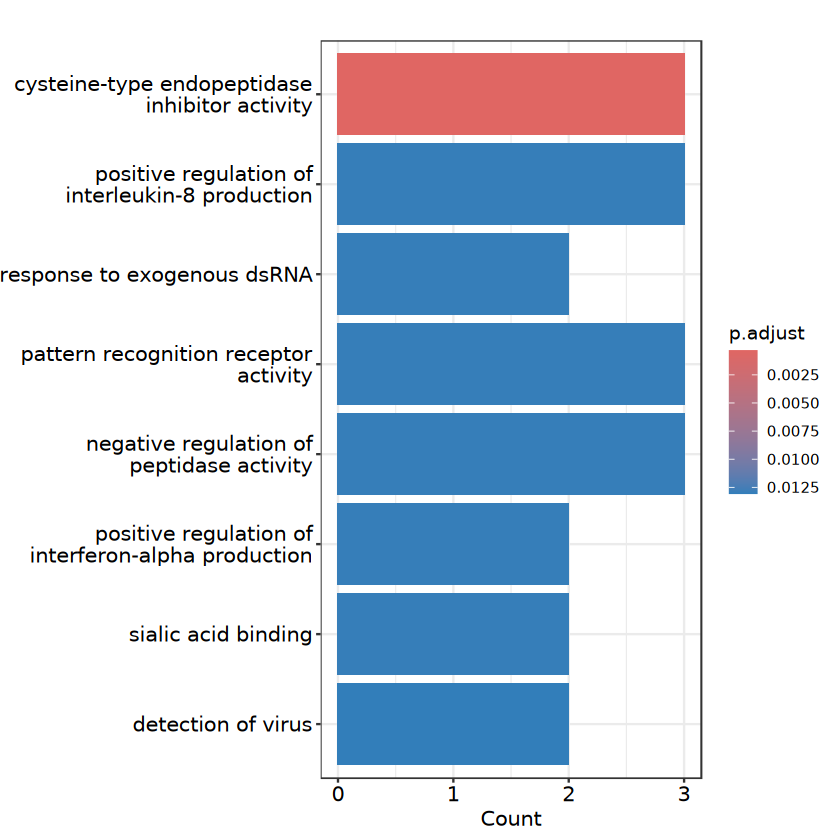

In [25]:
# warm vs. control
barplot(res_sig.w.c)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


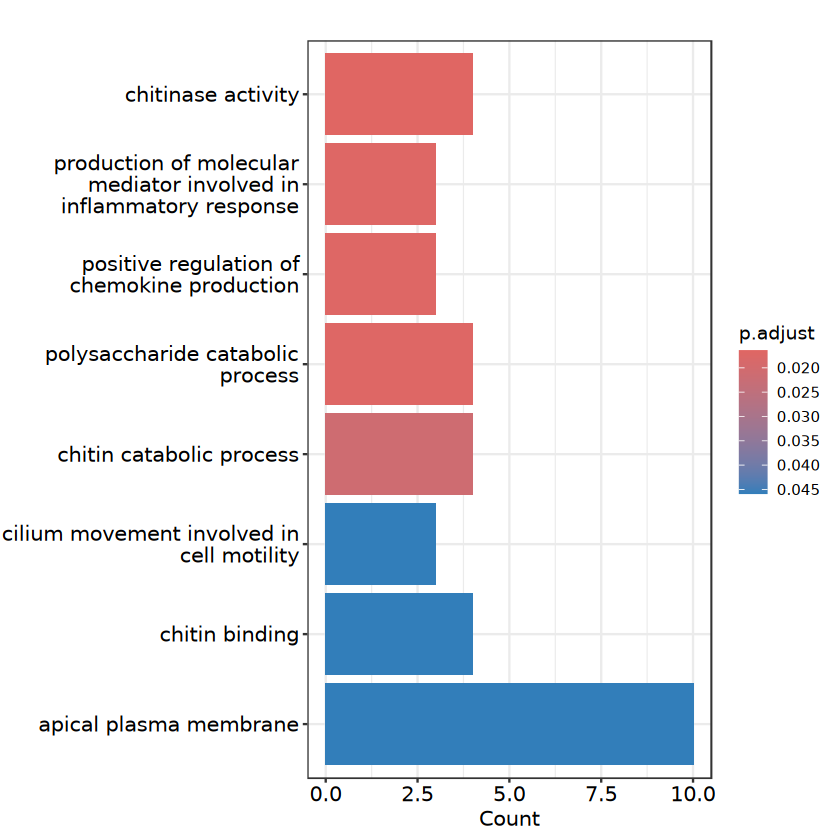

In [26]:
# both vs. control
barplot(res_sig.b.c)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


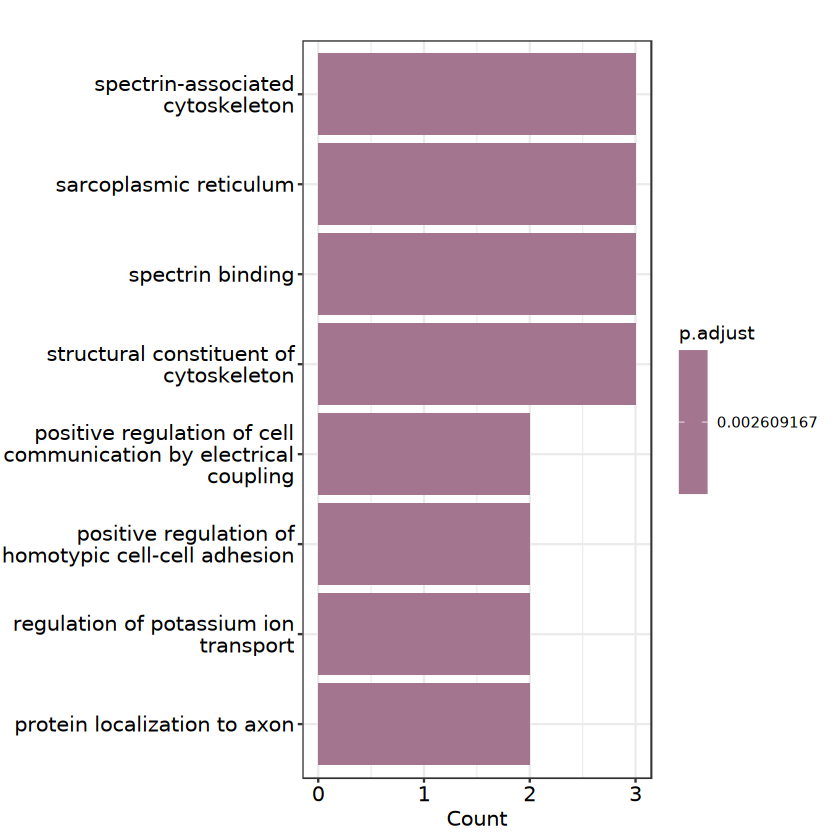

In [27]:
# hypoxic vs. control
barplot(res_sig.h.c)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


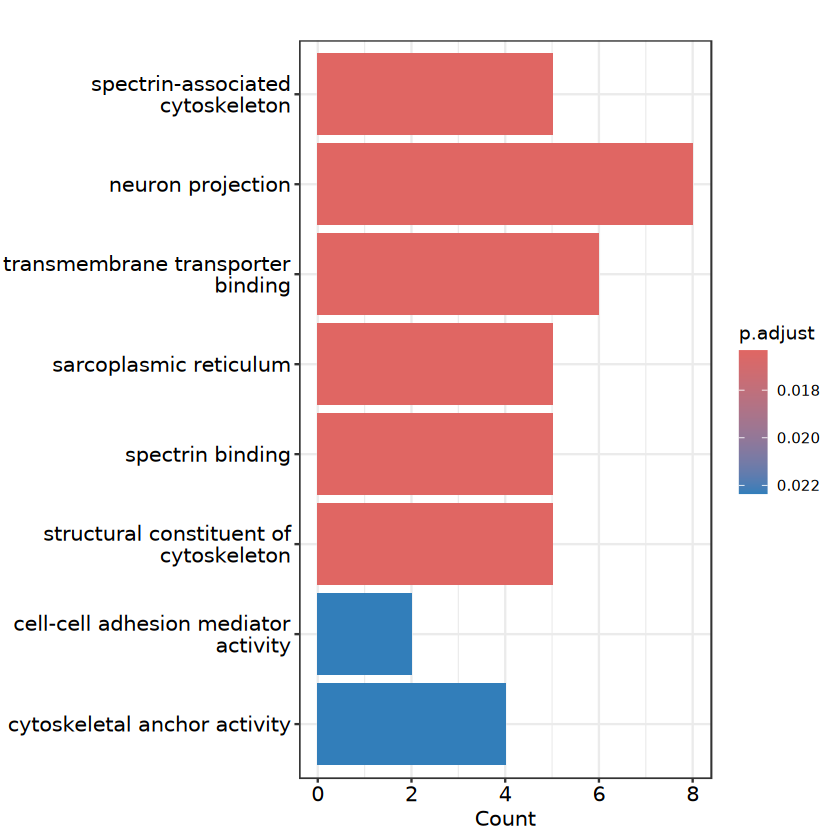

In [28]:
# hypoxic vs. both
barplot(res_sig.h.b)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


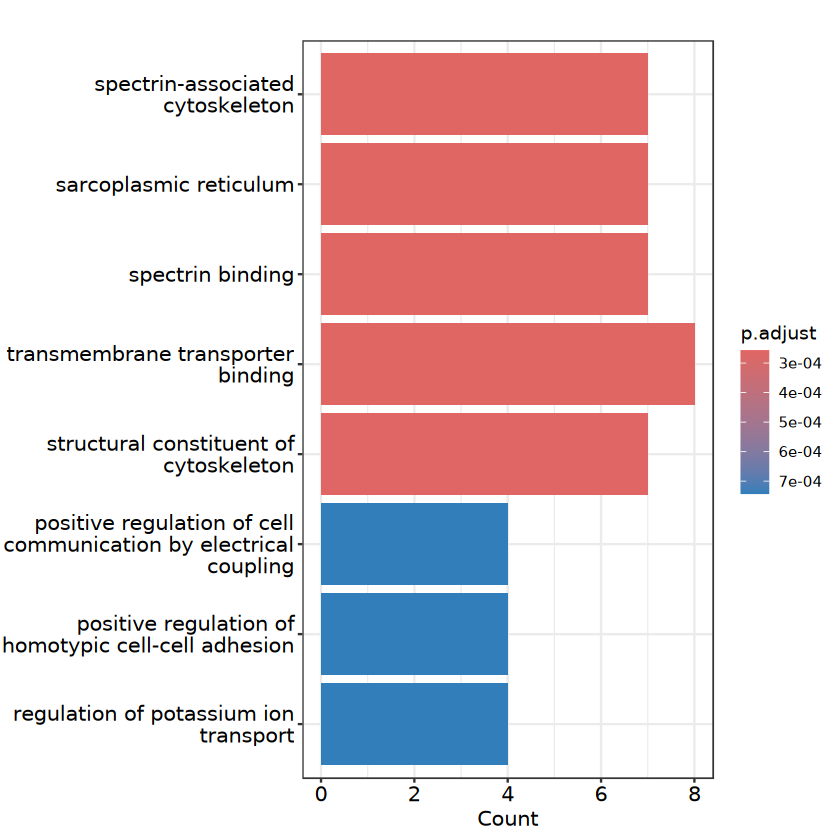

In [29]:
# warm vs. both
barplot(res_sig.w.b)

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


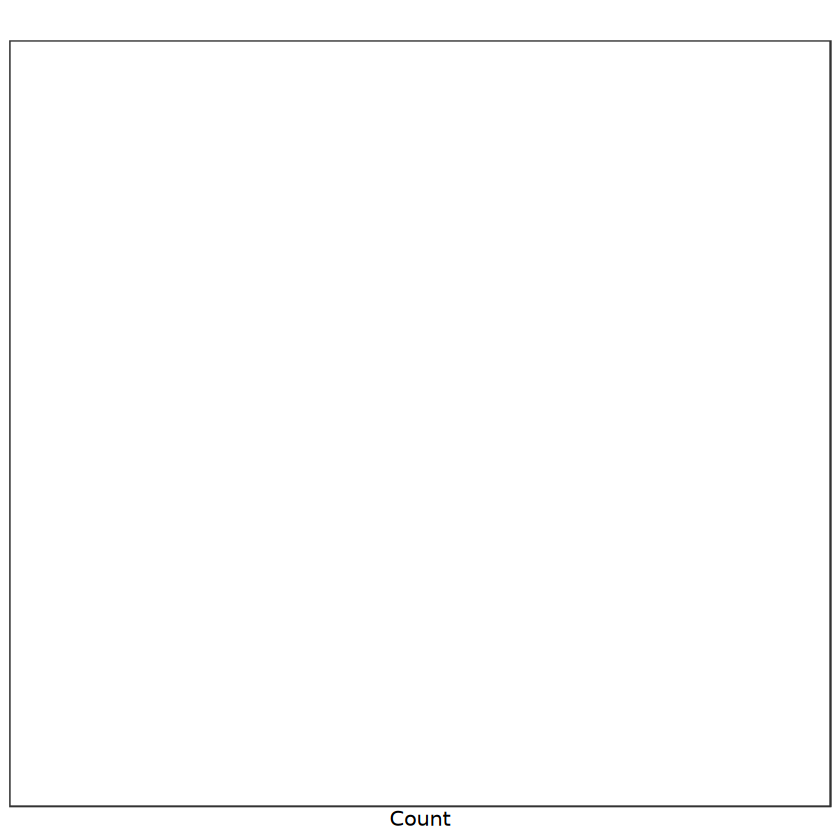

In [31]:
# warm vs. hypoxic
barplot(res_sig.w.h) # has no enriched terms so plot isn't showing anything - makes sense

### upset plots

In [58]:
head(res_sig.h.c, 2)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,3/11,135/16641,8.214949e-05,0.002609167,0.000757653,LOC111108483/LOC111105823/LOC111113858,3
GO:0016529,GO:0016529,sarcoplasmic reticulum,3/11,154/16641,1.214463e-04,0.002609167,0.000757653,LOC111108483/LOC111105823/LOC111113858,3


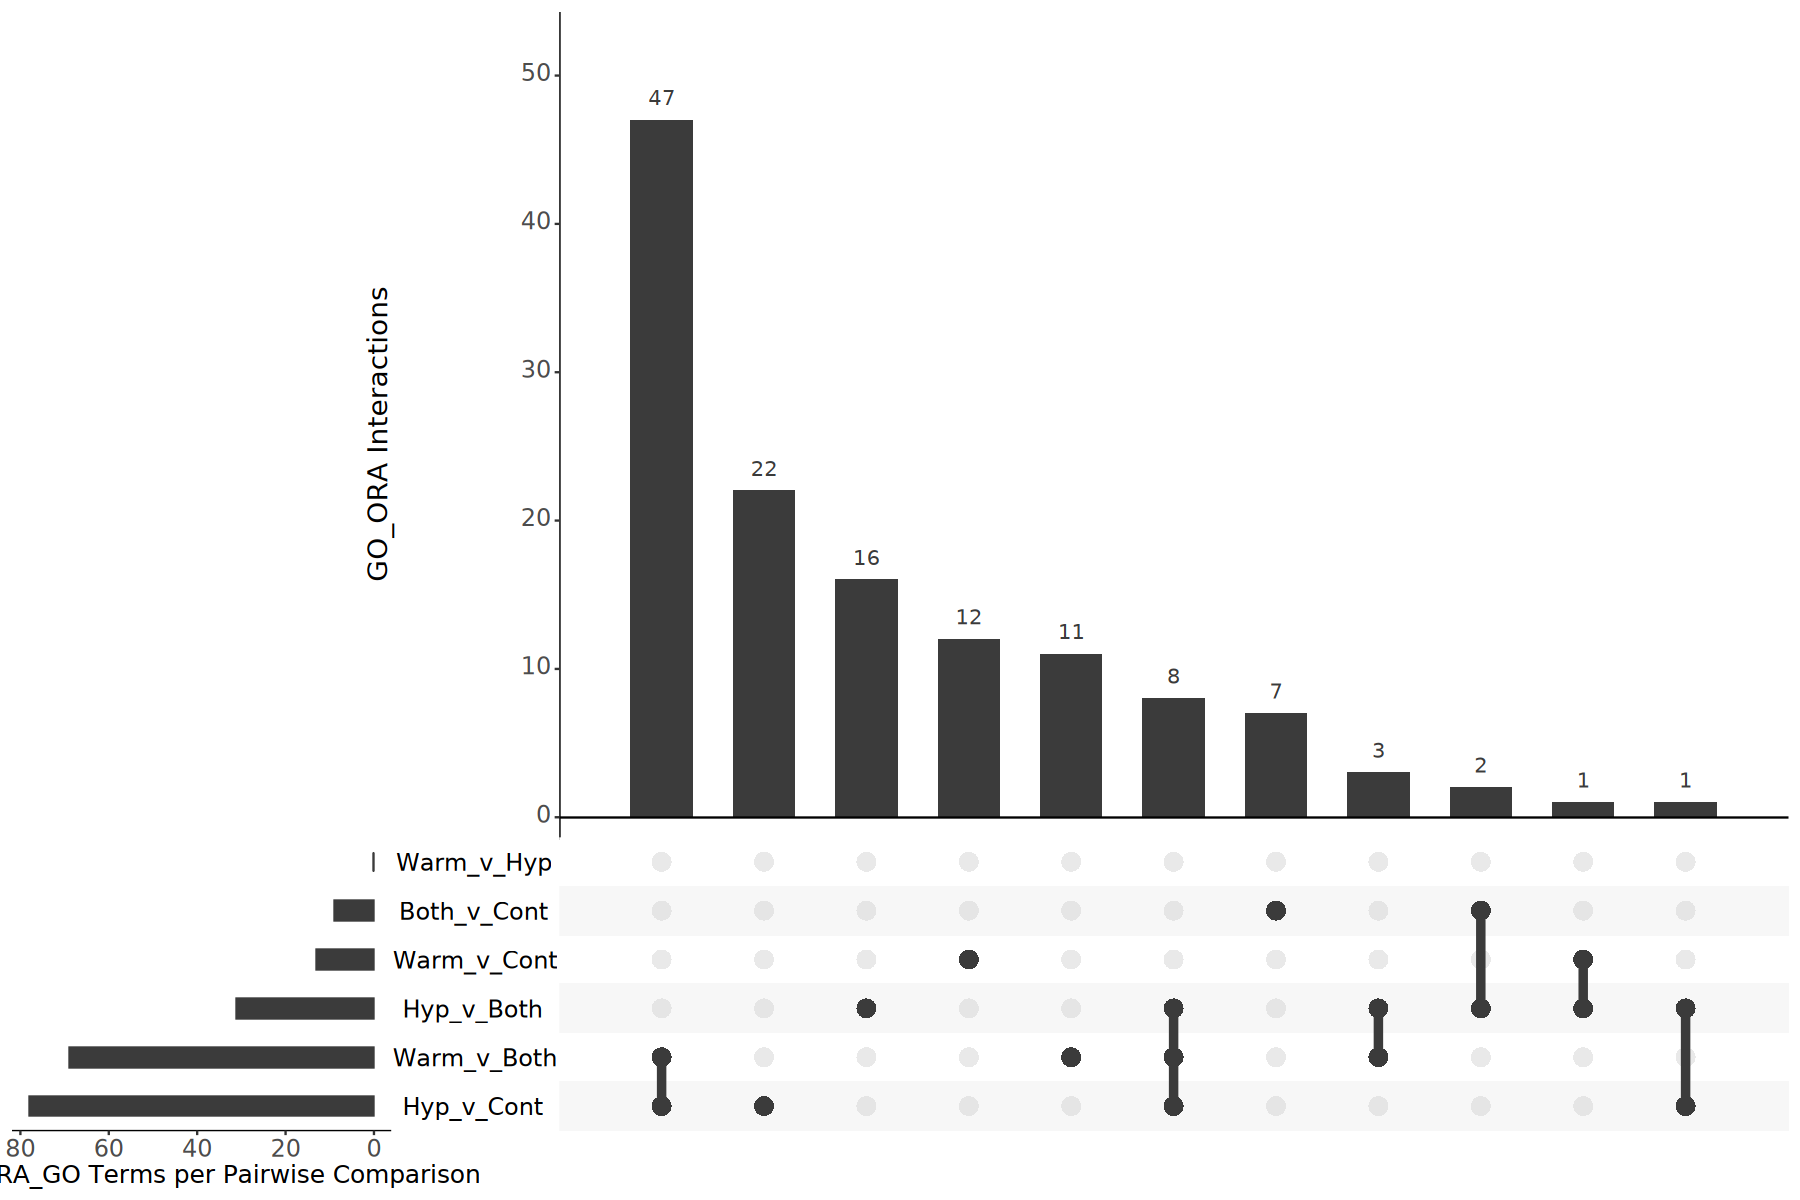

In [62]:
options(repr.plot.width=15, repr.plot.height=10)

all_list = list(Hyp_v_Both = res_sig.h.b$ID,
              Warm_v_Both = res_sig.w.b$ID,
              Warm_v_Hyp = res_sig.w.h$ID,
               Hyp_v_Cont = res_sig.h.c$ID,
               Warm_v_Cont = res_sig.w.c$ID,
               Both_v_Cont = res_sig.b.c$ID)

upset(fromList(all_list), nsets = 6,, order.by='freq', point.size = 5, line.size = 2, 
    mainbar.y.label = "GO_ORA Interactions", sets.x.label = "Sig. ORA_GO Terms per Pairwise Comparison", 
    text.scale = c(2, 2, 1.75, 2, 2, 2))

as a reminder - ORA is asking out of the list of differentially expressed genes, are there any gene sets that are over-represented? 

Here, we're looking at the overlap of significantly over-represented GO terms within our list of DEGs

Surprisingly, Hyp vs. Cont and Warm vs. Both have the most overlap in GO terms - so those gene sets (and probably related functions) are seen more in DEGs than you would expect by change - looking at the upset plot of just DEGs in [venn_p1.v.p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/venn_p1.v.p1.ipynb), these comparisons shared some DEGs, but not a ton (and none shared uniquely between these comparisons)

this might suggest that while the DEGs are different, there's some functional redundancy/similar pathways affected